## Text Summarization of BBC News Using Pegasus Transformer Model

Model Named on My HuggingFace Profile: 'pegasus-multi_news-NewsSummarization_BBC'


Source for Dataset: https://www.kaggle.com/datasets/pariza/bbc-news-summary

### Exploratory Data Analysis

#### Importing Necessary Libraries

In [1]:
import os, sys, csv
os.environ['TOKENIZERS_PARALLELISM']='false'

import torch
import torch.nn

import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from transformers import PegasusForConditionalGeneration, PegasusTokenizer, set_seed
from transformers import get_scheduler, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer 

from datasets import Dataset, DatasetDict, load_metric, load_dataset

#### Versions of Some Necessary Libraries Used

In [2]:
print("Pandas:".ljust(8), pd.__version__)
print("NumPy:".ljust(8), np.__version__)
print("Torch:".ljust(8), torch.__version__)
print("Python:".ljust(8), sys.version[0:6])

Pandas:  1.4.4
NumPy:   1.23.3
Torch:   1.12.1
Python:  3.9.7 


#### Define Basic Constants/Values

In [3]:
model_ckpt = 'google/pegasus-multi_news'
device="cpu"
vocab_size = 96103

max_input_length = 1024
max_target_length = 455

set_seed(42)

#### Ingest Dataset into Pandas

In [4]:
data = []
topics = ['business', 'entertainment', 'politics', 'sport', 'tech']

articles_path = '/Users/leedunn/Desktop/Projects to Train/BBC with Pegasus/News Articles/'
articles = pd.Series(name='Article', dtype=str)

summaries_path = '/Users/leedunn/Desktop/Projects to Train/BBC with Pegasus/Summaries/'
summaries = pd.Series(name='Summary', dtype=str)

# Loop through for each of the 5 'News' topics
for topic in topics:
    topic_length = 0
    a_dir_path = os.path.join(articles_path, topic)
    
    # Find the number of files in the directory for each 'News' topic
    for path in os.listdir(a_dir_path):
        if os.path.isfile(os.path.join(a_dir_path, path)):
            topic_length += 1
        
    # Ingest the 'article' text into a DataFrame
    for x in range(1,topic_length):
        a_current_data = pd.Series(dtype=str)
        with open((a_dir_path + r'/' + str(x).zfill(3) + r'.txt'), 'r', encoding=None) as f: 
            file = f.read()
            file = file.replace('\n', ' ')
            a_current_data = pd.Series(data=file)
            articles = pd.concat([a_current_data, articles], ignore_index=True)

    articles = pd.DataFrame(articles)
    articles = articles.set_index(topic + articles.index.astype(str))

    s_dir_path = os.path.join(summaries_path, topic)

    # Ingest the 'article' text into a DataFrame
    for x in range(1,topic_length):
        s_current_data = pd.Series(dtype=str)
        with open((s_dir_path + r'/' + str(x).zfill(3) + r'.txt'), 'r', encoding=None) as f: 
            file = f.read()
            file = file.replace('\n', ' ')
            s_current_data = pd.Series(data=file)
            summaries = pd.concat([s_current_data, summaries], ignore_index=True)

    summaries = pd.DataFrame(summaries)
    summaries = summaries.set_index(topic + summaries.index.astype(str))

articles = articles.rename(columns={0 : 'Articles'})
summaries = summaries.rename(columns={0 : 'Summaries'})

data = articles.join(summaries)
data.tail(25)


,Articles,Summaries
tech2195,Yukos loses US bankruptcy battle A judge has ...,The court ruling is a blow to efforts to get d...
tech2196,US trade gap hits record in 2004 The gap betw...,The Commerce Department said the trade deficit...
tech2197,Mixed signals from French economy The French ...,Despite the apparent shortfall in annual econo...
tech2198,Sluggish economy hits German jobs The number ...,But officials said stagnant growth was still s...
tech2199,Rank 'set to sell off film unit' Leisure grou...,Leisure group Rank could unveil plans to demer...
tech2200,Call centre users 'lose patience' Customers t...,The drop in patience comes as the number of ca...
tech2201,India widens access to telecoms India has rai...,"""We need at least $20bn (£10.6bn) in investmen..."
tech2202,India's rupee hits five-year high India's rup...,India's rupee has hit a five-year high after S...
tech2203,"Parmalat boasts doubled profits Parmalat, the...","On Tuesday, the company's administrator, turna..."
tech2204,China keeps tight rein on credit China's effo...,The breakneck pace of economic expansion has k...


#### Remove Unnecessary Whitespace

In [5]:
# Replace the '\n' with a space
data.replace('\n', ' ', inplace=True, regex=True)
data.replace('  ', ' ', inplace=True, regex=True)
data.reset_index(drop=True, inplace=True)

data

,Articles,Summaries
0,US cyber security chief resigns The man making...,Amit Yoran was director of the National Cyber ...
1,Be careful how you code A new European directi...,This goes to the heart of the European project...
2,Spam e-mails tempt net shoppers Computer users...,A third of them read unsolicited junk e-mail a...
3,BT program to beat dialler scams BT is introdu...,BT is introducing two initiatives to help beat...
4,New consoles promise big problems Making games...,Mr Walsh suggested that new studios should mak...
...,...,...
2215,Pernod takeover talk lifts Domecq Shares in UK...,Pernod has reduced the debt it took on to fund...
2216,High fuel prices hit BA's profits British Airw...,"Rod Eddington, BA's chief executive, said the ..."
2217,Yukos unit buyer faces loan claim The owners o...,Yukos' owner Menatep Group says it will ask Ro...
2218,Dollar gains on Greenspan speech The dollar ha...,The dollar has hit its highest level against t...


#### Visualize Length of Each Article

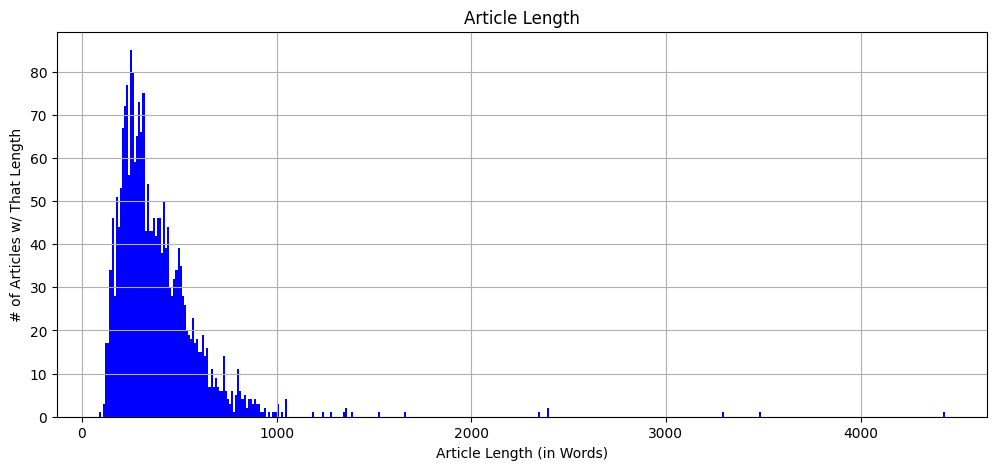

In [6]:
data['article_length'] = data['Articles'].str.split().apply(len)

data.hist("article_length", grid=True, color="Blue", figsize=(12,5), bins=410)
plt.suptitle('')
plt.xlabel('Article Length (in Words)')
plt.ylabel('# of Articles w/ That Length')
plt.title('Article Length')
plt.show()

#### Visualize Length of Each Summary

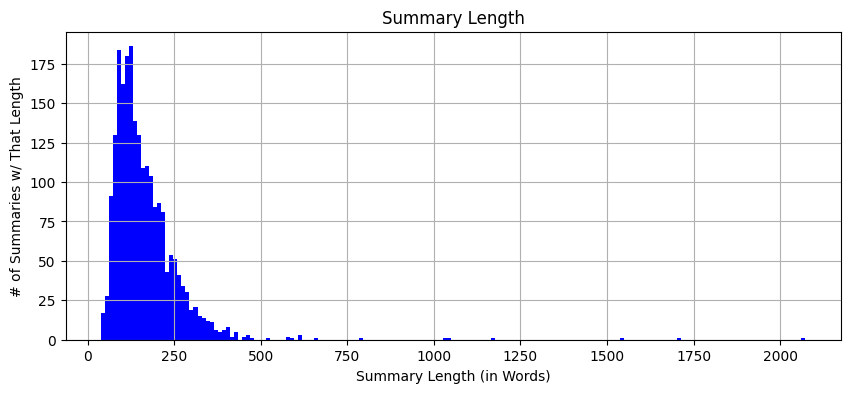

In [7]:
data['summary_length'] = data['Summaries'].str.split().apply(len)

data.hist("summary_length", grid=True, color="Blue", figsize=(10, 4), bins=175)
plt.suptitle('')
plt.xlabel('Summary Length (in Words)')
plt.ylabel('# of Summaries w/ That Length')
plt.title('Summary Length')
plt.show()

#### Trimmed Dataset Based on Article &/or Summary Length

In [8]:
data = data[data['article_length'] < 820]
data = data[data['summary_length'] < 350]

data = data.drop(columns=['article_length', 'summary_length'])

data

,Articles,Summaries
0,US cyber security chief resigns The man making...,Amit Yoran was director of the National Cyber ...
2,Spam e-mails tempt net shoppers Computer users...,A third of them read unsolicited junk e-mail a...
3,BT program to beat dialler scams BT is introdu...,BT is introducing two initiatives to help beat...
7,Savvy searchers fail to spot ads Internet sear...,Almost 50% of those questioned said they would...
8,Broadband fuels online expression Fast web acc...,More than five million households in the UK ha...
...,...,...
2215,Pernod takeover talk lifts Domecq Shares in UK...,Pernod has reduced the debt it took on to fund...
2216,High fuel prices hit BA's profits British Airw...,"Rod Eddington, BA's chief executive, said the ..."
2217,Yukos unit buyer faces loan claim The owners o...,Yukos' owner Menatep Group says it will ask Ro...
2218,Dollar gains on Greenspan speech The dollar ha...,The dollar has hit its highest level against t...


### Actual Project

#### Convert Pandas DataFrame to Datasets Format; Then Split into Train/Test/Valid Datasets

In [9]:
# Convert pandas dataframe to a dataset
dataset = Dataset.from_pandas(data)

# Split the datasetdict into train/test/valid subsets
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

# Combine the train/test/valid into one datasetdict
dataset = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

print('Training Data Shape:', dataset['train'].shape)
print('Testing Data Shape:', dataset['test'].shape)
print('Validation Data Shape:', dataset['valid'].shape)

Training Data Shape: (1714, 3)
Testing Data Shape: (215, 3)
Validation Data Shape: (214, 3)


#### Make Sure git lfs is Installed; Remember to Enter Access Token

In [10]:
# Access Token from HuggingFace...

!git lfs install

Git LFS initialized.


#### Instantiate both Tokenizer and Model

In [11]:
tokenizer = PegasusTokenizer.from_pretrained(model_ckpt, truncation=True, padding=True, batched=True, batch_size=None)

pipe = None

model = PegasusForConditionalGeneration.from_pretrained(model_ckpt)

#### Create Function to Tokenize & Return Necessary Inputs for Batches of Samples

In [12]:
def convert_examples_to_features(ex_batch):
    input_encodings = tokenizer(ex_batch['Articles'], max_length=max_input_length, truncation=True, padding=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(ex_batch['Summaries'], max_length=max_target_length, truncation=True, padding=True)
    return {"input_ids" : input_encodings["input_ids"],
            "attention_mask" : input_encodings["attention_mask"],
            "labels" : target_encodings["input_ids"],}

#### Apply Above Function to Dataset

In [13]:
encoded_ds = dataset.map(convert_examples_to_features, batched=True)
encoded_ds.set_format(type="torch", columns=['input_ids', 'labels', 'attention_mask'])

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Instantiate TrainingArguments

In [14]:
batch_size = 16
num_of_epochs = 2
logging_steps = 15
learning_rate=2e-5

model_name = f"{model_ckpt.split('/')[-1]}-NewsSummarization_BBC"

training_args = Seq2SeqTrainingArguments(output_dir=model_name,
                        num_train_epochs=num_of_epochs,
                        learning_rate=learning_rate,
                        per_device_train_batch_size=1,
                        per_device_eval_batch_size=1,
                        weight_decay=0.01,
                        save_strategy="epoch",
                        logging_strategy="epoch",
                        logging_first_step=True,
                        hub_strategy="checkpoint",
                        warmup_steps=50,
                        disable_tqdm=False,
                        logging_steps=logging_steps,
                        push_to_hub=True,
                        gradient_accumulation_steps=16,
                        log_level="error") 


#### Create Function to Computes Metrics

In [15]:
rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def compute_metrics(dataset, metric, model, tokenizer, column_text="Article", column_summary="Summary", batch_size=16, device=device):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=max_input_length, truncation=True, padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device), 
                                   attention_mask=inputs["attention_mask"].to(device), 
                                   length_penalty=0.8, num_beams=8, max_length=max_target_length)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

#### Instantiate Data Collator

In [16]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#### Instantiate Trainer

In [17]:
trainer = Seq2SeqTrainer(model=model, 
                  args=training_args,
                  data_collator=seq2seq_data_collator,
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['valid'], 
                  tokenizer=tokenizer) 

Cloning https://huggingface.co/DunnBC22/pegasus-multi_news-NewsSummarization_BBC into local empty directory.


#### Train Model

In [18]:
trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/214 [00:00<?, ?it/s]

{'loss': 8.06, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.01}
{'loss': 6.7693, 'learning_rate': 1.304878048780488e-05, 'epoch': 1.0}
{'loss': 6.0583, 'learning_rate': 0.0, 'epoch': 2.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'train_runtime': 413295.7412, 'train_samples_per_second': 0.008, 'train_steps_per_second': 0.001, 'train_loss': 6.419796105857207, 'epoch': 2.0}


TrainOutput(global_step=214, training_loss=6.419796105857207, metrics={'train_runtime': 413295.7412, 'train_samples_per_second': 0.008, 'train_steps_per_second': 0.001, 'train_loss': 6.419796105857207, 'epoch': 2.0})

### Model Evaluation

#### Compute & Print Metrics

In [19]:
rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

score = compute_metrics(dataset["test"], 
                        rouge_metric, 
                        trainer.model, 
                        tokenizer, 
                        batch_size=2, 
                        column_text='Articles', 
                        column_summary='Summaries')

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"Pegasus"])

100%|██████████| 108/108 [8:34:02<00:00, 285.57s/it]  


,rouge1,rouge2,rougeL,rougeLsum
Pegasus,0.584474,0.463574,0.408729,0.408431


#### Print Out Full Rouge Metric Dictionary

In [20]:
print("Full Score Dictionary:\n", score)

Full Score Dictionary:
 {'rouge1': AggregateScore(low=Score(precision=0.6613047653270004, recall=0.5193497486512931, fmeasure=0.5671636136444602), mid=Score(precision=0.6822257872229608, recall=0.5428290872118673, fmeasure=0.5844740004724716), high=Score(precision=0.7023678196557687, recall=0.5668502135331891, fmeasure=0.6018339883629311)), 'rouge2': AggregateScore(low=Score(precision=0.5154365493216139, recall=0.40760524371275686, fmeasure=0.44154084371546704), mid=Score(precision=0.5402554310207854, recall=0.4308105876045223, fmeasure=0.46357401042162877), high=Score(precision=0.5679967652425573, recall=0.4556323037626598, fmeasure=0.4858891718623728)), 'rougeL': AggregateScore(low=Score(precision=0.457444276150138, recall=0.3600848942197825, fmeasure=0.3909794266174622), mid=Score(precision=0.4770079871410392, recall=0.3803817074077177, fmeasure=0.4087285153152276), high=Score(precision=0.4977068118625476, recall=0.4001819701412991, fmeasure=0.424896992792248)), 'rougeLsum': Aggrega

### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [21]:
trainer.push_to_hub(commit_message="All Dunn!")

To https://huggingface.co/DunnBC22/pegasus-multi_news-NewsSummarization_BBC
   472c3dd..0f792f0  main -> main

   472c3dd..0f792f0  main -> main

To https://huggingface.co/DunnBC22/pegasus-multi_news-NewsSummarization_BBC
   0f792f0..d6db132  main -> main

   0f792f0..d6db132  main -> main



'https://huggingface.co/DunnBC22/pegasus-multi_news-NewsSummarization_BBC/commit/0f792f04f499f2f6d633589c4926a2c09ec6e636'